# Deep Q-Networks

## Lab policy

- This lab is a mandatory part of the "Reinforcement Learning" course.
The solution is graded from 0 to 10.
The average of the Python labs counts for 50% of the final grade.

- This lab is to be solved **individually**.

- The solution consists of a copy of this notebook, containing your implementations and algorithm analysis.
It will be sent by email to florin.gogianu@gmail.com.

- The deadline for submitting the solution is **January 23, 2025, by 23:59**.
Late submission is accepted, but the maximum grade is reduced by half: 5 points.
The time required to complete the lab depends on experience with Python programming, but part of the work will need to be done at home.
It is strongly recommended that you do not wait until right before the deadline to finish the solution.

- Discussion of ideas between groups is encouraged, but reusing code or reports (even partially) is not allowed. **Violation of this rule (copying) will result in immediate loss of the right to take the exam**.

- A discussion session will be organized and will include detailed technical questions related to your implementation.

In [ ]:
!pip install minatar

In [ ]:
import itertools
import random
from argparse import Namespace
from collections import deque, defaultdict
from copy import deepcopy

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as O

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from minatar import Environment
#from minatar.gui import GUI

print(f"PyTorch   : {torch.__version__}.  \tShould be: >=1.10.x+cu100")

PyTorch   : 2.5.1+cu121.  	Should be: >=1.10.x+cu100


In [ ]:
sns.set()
%matplotlib inline

In [ ]:
#DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cpu")
print(DEVICE)

cpu


## Part 1. Code walkthrough

In [ ]:
# a function you can use to reset the random number generators in this runtime
def reset_rng(seed=42):
    print(f"Setting all rngs to seed={seed}")
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

reset_rng()

Setting all rngs to seed=42


In [ ]:
# plotting utility
def plot_stats(stats, y="ep_rewards", hue=None, window=10):
    df = pd.DataFrame(stats)

    if window:
        new_col = f"avg_{y}"
        if hue is not None:
            df[new_col] = df.groupby(hue)[y].rolling(window=window).mean().reset_index(0,drop=True)
        else:
            df[new_col] = df[y].rolling(window=window).mean()

    y = f"avg_{y}" if window else y
    with matplotlib.rc_context({'figure.figsize':(10, 6)}):
        sns.lineplot(x="step_idx", y=y, hue=hue, data=df)

In [ ]:
class Gym:
    def __init__(self, mdp_name):
        self.mdp = Environment(mdp_name)
        self.actions = self.mdp.minimal_action_set()
        print("{}: {} actions  |  state shape {}".format(
            self.mdp.env_name, self.actions, self.mdp.state_shape()
        ))

    def reset(self):
        self.mdp.reset()
        return self._np2th(self.mdp.state()), self.mdp.env.terminal

    def step(self, action_idx):
        assert -1 < action_idx < self.num_action, f"Actions should be between 0 and {self.num_action}."
        reward, done = self.mdp.act(self.actions[action_idx])
        return self._np2th(self.mdp.state()), reward, done

    def _np2th(self, obs):
        return torch.tensor(obs).permute(2, 0, 1).unsqueeze(0).float()

    @property
    def num_action(self):
        return len(self.actions)

    @property
    def observation_shape(self):
        s = self.mdp.state_shape()
        return [1, s[-1], *s[:-1]]

    def display(self):
        obs = self.mdp.state()
        obs_ = np.amax(obs * np.reshape(np.arange(obs.shape[-1]) + 1, (1,1,-1)), 2) + 0.5
        sns.heatmap(obs_, cbar=None, square=True, yticklabels=False, xticklabels=False)
        plt.show(block=False)

### How to interact with the environment

In [ ]:
sim = Gym("breakout")
random_policy = lambda: torch.randint(sim.num_action, (1,)).item()

ep_num, tot_reward, tot_steps = 100_000, 0, 0
for ep in range(ep_num):

    # each episode starts with resetting the environment
    observation, done = sim.reset()

    while not done:
        # compute an action using some policy
        action = random_policy()

        # use the action to increment the environment
        observation, reward, done = sim.step(action)

        tot_reward += reward
        tot_steps += 1
print("Performanța politicii aleatoare: {:3.2f} reward/ep in {:3.1f} steps/ep.".format(
    tot_reward/ep_num, tot_steps/ep_num
))

breakout: [0, 1, 3] actions  |  state shape [10, 10, 4]
Performanța politicii aleatoare: 0.38 reward/ep in 9.9 steps/ep.


### Understanding the observation space

MinAtar observations are 10 by 10 "images" with 4 and up to 6 channels (instead of the regular 3 in RGBs).

The special format is to make sure the observations obey the Markov property.

breakout: [0, 1, 3] actions  |  state shape [10, 10, 4]


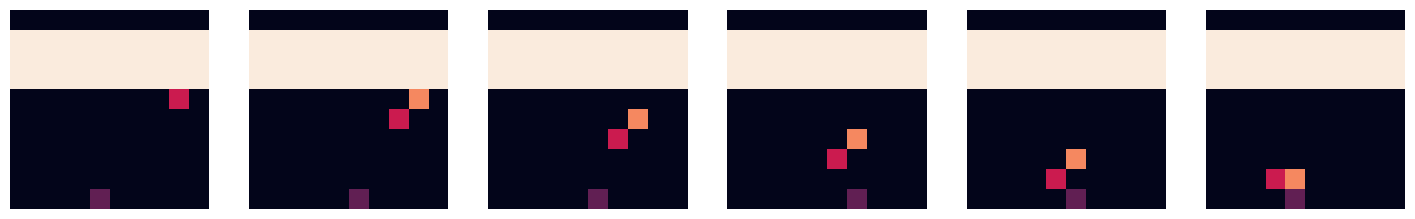

In [ ]:
sim = Gym("breakout")
policy = lambda: torch.randint(sim.num_action, (1,)).item()
step_num, observations = 6, []

sim.reset()
for _ in range(step_num):
    obs, _, _ = sim.step(policy())
    observations.append(obs.squeeze().permute(1,2,0).numpy())

_, axs = plt.subplots(1, step_num, figsize=(3 * step_num, 3))
for ax, obs in zip(axs, observations):
    obs_ = np.amax(obs * np.reshape(np.arange(obs.shape[-1]) + 1, (1,1,-1)), 2) + 0.5
    sns.heatmap(obs_, cbar=None, square=True, xticklabels=False, yticklabels=False, ax=ax)

### The training loop

It takes an agent and an environment and implements the agent-environment interaction loop

In [ ]:
def train(agent, env, step_num=100_000, log_freq=50):

    stats, N = {"step_idx": [0], "ep_rewards": [0.0], "ep_steps": [0.0]}, 0

    state, done = env.reset()
    for step in range(step_num):

        action = agent.step(state)
        state_, reward, done = env.step(action)
        agent.learn(state, action, reward, state_, done)

        # some envs just update the state and are not returning a new one
        state = state_.clone()

        # stats
        stats["ep_rewards"][N] += reward
        stats["ep_steps"][N] += 1

        if done:
            # episode done, reset env!
            state, done = env.reset()

            # some more stats
            if (N % log_freq) == 0 and N != 0:
                print("[{0:3d}][{1:6d}], R/ep={2:6.2f}, steps/ep={3:2.0f}.".format(
                    N, step,
                    torch.tensor(stats["ep_rewards"][-10:]).mean().item(),
                    torch.tensor(stats["ep_steps"][-10:]).mean().item(),
                ))

            stats["ep_rewards"].append(0.0)  # reward accumulator for a new episode
            stats["ep_steps"].append(0.0)    # reward accumulator for a new episode
            stats["step_idx"].append(step)
            N += 1

    print("[{0:3d}][{1:6d}], R/ep={2:6.2f}, steps/ep={3:2.0f}.".format(
        N, step, torch.tensor(stats["ep_rewards"][-10:]).mean().item(),
        torch.tensor(stats["ep_steps"][-10:]).mean().item(),
    ))
    stats["agent"] = [agent.__class__.__name__ for _ in range(N+1)]
    return stats

## Part II. Deep Q-Networks implementation

For a refresher on the DQN algorithm, you can use the following resources:

- [lecture slides](https://busoniu.net/teaching/rl2024/slides_drl_handout_2024.pdf)
- [original paper](https://arxiv.org/abs/1312.5602)


### Task 1 [3pts]. Experience Replay

Implement the `sample` method.

In [ ]:
class ReplayMemory:
    def __init__(self, size=1000, batch_size=32):
        self._buffer = deque(maxlen=size)
        self._batch_size = batch_size

    def push(self, transition):
        self._buffer.append(transition)

    def sample(self):
        """ Sample from self._buffer

            Should return a tuple of tensors of size:
            (
                states:     N * C * H * W,  (torch.uint8)
                actions:    N * 1, (torch.int64)
                rewards:    N * 1, (torch.float32)
                states_:    N * C * H * W,  (torch.uint8)
                done:       N * 1, (torch.uint8)
            )

            where N is the batch_size, C is the number of channels.

            WARNING, this method must not change the contents of `self._buffer`!
        """
        # sample batch_size elements from the buffer
        N = self._batch_size
        C = self._buffer[1][0].size(1)
        H = self._buffer[1][0].size(2)
        W = self._buffer[1][0].size(3)
        buffer_len = len(self._buffer)

        rand_sam = torch.randint(0,buffer_len,(self._batch_size,))

        states = torch.zeros(N,C,H,W)
        actions = torch.zeros(N,1)
        rewards = torch.zeros(N,1)
        states_ = torch.zeros(N,C,H,W)
        done=torch.zeros(N,1)
        for i in range(self._batch_size):
          observation = self._buffer[rand_sam[i].item()]
          states[i] = observation[0].view(C,H,W)
          actions[i] = observation[1]
          rewards[i] = observation[2]
          states_[i] = observation[3].view(C,H,W)
          done[i] = observation[4]

        samples=(states,actions,rewards,states_,done)
        # reshape, convert if needed, put on device (use torch.to(DEVICE))
        return samples

    def __len__(self):
        return len(self._buffer)

In [ ]:
mem = ReplayMemory(size=5, batch_size=2)
mem.push((torch.rand(1,4,10,10) , 0 , 0.1 , torch.rand(1,4,10,10) , False))
mem.push((torch.rand(1,4,10,10) , 0 , 0.1 , torch.rand(1,4,10,10) , False))
mem.push((torch.rand(1,4,10,10) , 0 , 0.1 , torch.rand(1,4,10,10) , False))
mem.push((torch.rand(1,4,10,10) , 0 , 0.1 , torch.rand(1,4,10,10) , False))
mem.push((torch.rand(1,4,10,10) , 0 , 0.1 , torch.rand(1,4,10,10) , False))

a=mem.sample()
a



(tensor([[[[0.9527, 0.9570, 0.0765, 0.7017, 0.7661, 0.7344, 0.2759, 0.8572,
            0.5427, 0.6456],
           [0.9701, 0.4439, 0.9384, 0.1516, 0.6668, 0.9863, 0.4695, 0.1449,
            0.9678, 0.4593],
           [0.6931, 0.4047, 0.4125, 0.4114, 0.0099, 0.9664, 0.4974, 0.5271,
            0.4806, 0.5159],
           [0.8789, 0.4986, 0.5862, 0.4188, 0.7773, 0.8378, 0.1319, 0.2446,
            0.4782, 0.5428],
           [0.2601, 0.5836, 0.1372, 0.3339, 0.4491, 0.0510, 0.1475, 0.2133,
            0.1309, 0.6789],
           [0.3145, 0.0239, 0.8969, 0.2110, 0.5865, 0.7651, 0.8922, 0.0484,
            0.9279, 0.1097],
           [0.2361, 0.0860, 0.1854, 0.3925, 0.2954, 0.7887, 0.0797, 0.4445,
            0.6647, 0.7535],
           [0.3276, 0.1551, 0.4790, 0.6103, 0.1659, 0.2090, 0.8433, 0.1282,
            0.7623, 0.2662],
           [0.6926, 0.0446, 0.8195, 0.5656, 0.5687, 0.3420, 0.5950, 0.4087,
            0.1885, 0.9812],
           [0.2236, 0.1594, 0.5240, 0.3219, 0.2745, 0.7

### Task 2 [1pt]. Epsilon-greedy exploration

Implement an epsilon-greedy exploration schedule.

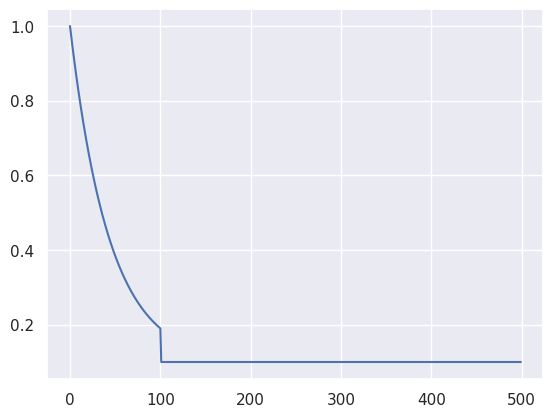

In [ ]:
import math
def get_epsilon_schedule(start=1.0, end=0.1, steps=500):
    """ Returns either:
        - a generator of epsilon values
        - a function that receives the current step and returns an epsilon

        The epsilon values returned by the generator or function need
        to be degraded from the `start` value to the `end` within the number
        of `steps` and then continue returning the `end` value indefinetly.

        You can pick any schedule (exp, poly, etc.). I tested with linear decay.
    """
    #I picked the exponential decay schedule
    t=0
    rate = -math.log(0.1) / steps
    while True:
      if t <= steps:
        epsilon = end + (start - end) * math.exp(-rate * t)
      else:
        epsilon = end
      yield epsilon
      t += 1



# test it, it needs to look nice
epsilon = get_epsilon_schedule(1.0, 0.1, 100)
plt.plot([next(epsilon) for _ in range(500)])


### Neural Network Function Approximation

Before we continue, take a look at the neural network we defined for you.

In [ ]:
def get_estimator(action_num, input_ch=3, cnv_width=32, lin_width=64):
    return nn.Sequential(
        nn.Conv2d(input_ch, cnv_width, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.Conv2d(cnv_width, cnv_width, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.Conv2d(cnv_width, cnv_width, kernel_size=2),
        nn.ReLU(inplace=True),
        nn.Flatten(),
        nn.Linear(25 * cnv_width, lin_width),  # number of pixels in the feature map
        nn.ReLU(inplace=True),
        nn.Linear(lin_width, action_num),
    ).to(DEVICE)

### Task 3. Deep Q-Network algorithm

You will have to implement the following:

- a) `step()` method [1pt]
- b) `learn()` method [1pts]
- c) `_update()` method [4pts]

In [ ]:
class DQN:
    def __init__(
        self,
        estimator,
        buffer,
        optimizer,
        epsilon_schedule,
        action_num,
        gamma=0.92,
        update_steps=4,
        update_target_steps=10,
        warmup_steps=100,
    ):
        self._estimator = estimator
        self._target_estimator = deepcopy(estimator)
        self._buffer = buffer
        self._optimizer = optimizer
        self._epsilon = epsilon_schedule
        self._action_num = action_num
        self._gamma = gamma
        self._update_steps=update_steps
        self._update_target_steps=update_target_steps
        self._warmup_steps = warmup_steps
        self._step_cnt = 0
        assert warmup_steps > self._buffer._batch_size, (
            "You should have at least a batch in the ER.")

    def step(self, state):
        # implement an epsilon greedy policy using the
        # estimator and epsilon schedule attributes.

        # warning, you should make sure you are not including
        # this step into torch computation graph (remember torch.detach()
        # and torch.no_grad())

        # TODO: return the action according to the self._epsilon schedule
        # you defined earlier
        with torch.no_grad():
          if torch.rand(1)<(1-next(self._epsilon)):
            u=self._estimator(state).argmax()
          else:
            u=torch.randint(low=0,high=2,size=(1,1))
        return u.item()


    def learn(self, state, action, reward, state_, done):

        # TODO: add transition to the experience replay
        self._buffer.push((state,action,reward,state_,done))

        if self._step_cnt < self._warmup_steps:
            self._step_cnt += 1
            return

        # TODO: sample from experience replay and do an update
        if self._step_cnt % self._update_steps == 0:
            states, actions, rewards, states_, done=self._buffer.sample()
            self._update(states, actions, rewards, states_, done)


        # TODO: update the target estimator (hint, use pytorch state_dict methods)
        if self._step_cnt % self._update_target_steps == 0:
          self._target_estimator.load_state_dict(self._estimator.state_dict())

        self._step_cnt += 1

    def _update(self, states, actions, rewards, states_, done):
        # TODO: compute the Deep Q-Network update. Careful not to include the
        # target network in the computational graph.

        # Compute Q(s, * | θ) and Q(s', . | θ^)
        q_values = self._estimator(states)
        with torch.no_grad():
          q_values_ = self._target_estimator(states_)

        # compute Q(s, a) and max_a' Q(s', a')
        #can use gather method from torch
        actions = actions.to(torch.int64)
        qsa = q_values.gather(1,actions)
        qsa_ = q_values_.max(1,keepdim=True)[0]
        qsa_ = qsa_ * (1 - done)

        # compute target values
        target_qsa = rewards + self._gamma * qsa_

        # at this step you should check the target values
        # are looking about right :). You can use this code.
        # if rewards.squeeze().sum().item() > 0.0:
        #     print("R: ", rewards.squeeze())
        #     print("T: ", target_qsa.squeeze())
        #     print("D: ", done.squeeze())

        # compute the loss and average it over the entire batch
        loss = torch.nn.functional.mse_loss(qsa,target_qsa)

        # backprop and optimize
        self._optimizer.zero_grad()
        loss.backward()
        self._optimizer.step()


In [ ]:
env = Gym("breakout")

breakout: [0, 1, 3] actions  |  state shape [10, 10, 4]


If your implementation is correct you should be able to run the following cell without errors.

The average episodic return should reach 5.0 with a proper implementation.

breakout: [0, 1, 3] actions  |  state shape [10, 10, 4]
[ 50][   335], R/ep=  0.10, steps/ep= 7.
[100][   655], R/ep=  0.00, steps/ep= 6.
[150][  1025], R/ep=  0.30, steps/ep= 9.
[200][  1465], R/ep=  0.40, steps/ep=10.
[250][  2027], R/ep=  0.80, steps/ep=14.
[300][  2601], R/ep=  0.40, steps/ep=10.
[350][  3263], R/ep=  0.60, steps/ep=12.
[400][  4229], R/ep=  1.60, steps/ep=23.
[450][  5119], R/ep=  1.50, steps/ep=22.
[500][  6203], R/ep=  1.40, steps/ep=21.
[550][  7439], R/ep=  2.80, steps/ep=35.
[600][  9007], R/ep=  2.10, steps/ep=28.
[650][ 11107], R/ep=  2.80, steps/ep=35.
[700][ 13537], R/ep=  4.20, steps/ep=51.
[750][ 15937], R/ep=  3.10, steps/ep=39.
[800][ 18895], R/ep=  6.10, steps/ep=71.
[850][ 21311], R/ep=  5.00, steps/ep=60.
[900][ 23843], R/ep=  4.80, steps/ep=58.
[950][ 26813], R/ep=  4.40, steps/ep=53.
[1000][ 29877], R/ep=  5.20, steps/ep=62.
[1050][ 32705], R/ep=  3.20, steps/ep=41.
[1100][ 35497], R/ep=  3.60, steps/ep=45.
[1150][ 38483], R/ep=  6.00, steps/ep=7

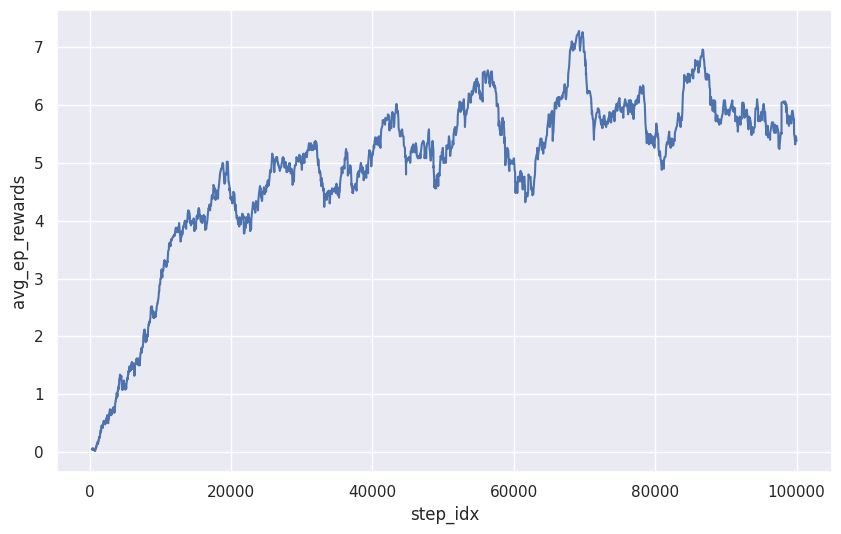

In [ ]:
env = Gym("breakout")
net = get_estimator(env.num_action, input_ch=env.observation_shape[1], cnv_width=16)

stats = train(
    DQN(
        net,
        ReplayMemory(size=10_000, batch_size=32),
        O.Adam(net.parameters(), lr=1e-3, eps=1e-5),
        get_epsilon_schedule(start=1.0, end=0.05, steps=10_000),
        env.num_action,
        warmup_steps=100,
        update_steps=1,
    ),
    env,
    step_num=100_000,  # change the experiment length if it's learning but not reaching about 5.0
    log_freq=50       # you can change this
)

# go ahead an plot the training stats
plot_stats(stats, window=50)

### Task 4. Deep Q-Network algorithm [not graded]

For the curiously inclined, one of the popular extensions to DQN is Double DQN, a simple modification which computes the target based on the target network value of the optimal actions of the online network.

To implement this algorithm you only need to change the `_update` method below.

For reference you can use: [Deep Reinforcement Learning with Double Q-Learning](https://arxiv.org/abs/1509.06461).

In [ ]:
class DoubleDQN(DQN):
    def _update(self, states, actions, rewards, states_, done):
        # TODO: compute the Deep Q-Network update. Careful not to include the
        # target network in the computational graph.
        actions = actions.to(torch.int64)


        # Compute Q(s, * | θ) and Q(s', . | θ^)
        q_values = self._estimator(states)
        qsa = q_values.gather(1,actions)
        act_size=actions.size()
        #print(actions.size())

        with torch.no_grad():
          q_values_online_ = self._estimator(states_)#compute future states q_values
          optim_actions_online = q_values_online_.argmax(1)#extracting the best actions from the future state
          #print(optim_actions_online.size())

          q_values_=self._target_estimator(states_)
          qsa_ = q_values_.gather(1,optim_actions_online.view(act_size[0],act_size[1]))#using target network to evaluate the value of the chosen actions
          qsa_ = qsa_ * (1 - done)


        # compute target values
        target_qsa = rewards + self._gamma * qsa_

        # at this step you should check the target values
        # are looking about right :). You can use this code.
        # if rewards.squeeze().sum().item() > 0.0:
        #     print("R: ", rewards.squeeze())
        #     print("T: ", target_qsa.squeeze())
        #     print("D: ", done.squeeze())

        # compute the loss and average it over the entire batch
        loss = torch.nn.functional.mse_loss(qsa,target_qsa)

        # backprop and optimize
        self._optimizer.zero_grad()
        loss.backward()
        self._optimizer.step()

In [ ]:
env = Gym("breakout")
net = get_estimator(env.num_action, input_ch=env.observation_shape[1], cnv_width=16)

stats = train(
    DoubleDQN(
        net,
        ReplayMemory(size=10_000, batch_size=32),
        O.Adam(net.parameters(), lr=1e-3, eps=1e-5),
        get_epsilon_schedule(start=1.0, end=0.05, steps=10_000),
        env.num_action,
        warmup_steps=100,
        update_steps=1,
    ),
    env,
    step_num=100_000,  # change the experiment length if it's learning but not reaching about 5.0
    log_freq=50       # you can change this
)

breakout: [0, 1, 3] actions  |  state shape [10, 10, 4]
[ 50][   345], R/ep=  0.20, steps/ep= 8.
[100][   665], R/ep=  0.20, steps/ep= 8.
[150][   985], R/ep=  0.10, steps/ep= 7.
[200][  1455], R/ep=  0.40, steps/ep=10.
[250][  1917], R/ep=  0.30, steps/ep= 9.
[300][  2513], R/ep=  1.00, steps/ep=16.
[350][  3175], R/ep=  1.10, steps/ep=17.
[400][  4145], R/ep=  0.90, steps/ep=15.
[450][  5109], R/ep=  1.10, steps/ep=17.
[500][  6323], R/ep=  1.80, steps/ep=25.
[550][  7685], R/ep=  2.30, steps/ep=30.
[600][  9403], R/ep=  2.50, steps/ep=33.
[650][ 11167], R/ep=  3.30, steps/ep=41.
[700][ 13033], R/ep=  2.90, steps/ep=37.
[750][ 15633], R/ep=  4.00, steps/ep=49.
[800][ 18113], R/ep=  4.10, steps/ep=50.
[850][ 20933], R/ep=  4.60, steps/ep=56.
[900][ 23867], R/ep=  3.30, steps/ep=41.
[950][ 26829], R/ep=  4.00, steps/ep=49.
[1000][ 30023], R/ep=  5.90, steps/ep=70.
[1050][ 33067], R/ep=  6.50, steps/ep=77.
[1100][ 36499], R/ep=  6.20, steps/ep=73.
[1150][ 39915], R/ep=  4.70, steps/ep=5

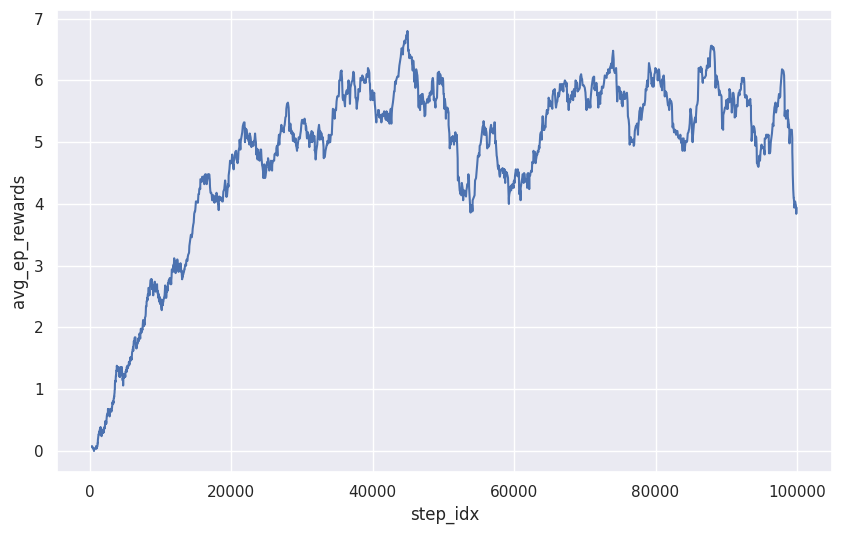

In [ ]:
plot_stats(stats, window=50)